# Machine Learning with PyTorch and Scikit-Learn  

#### CHANGES ####
Moved imports to a dedicated cell.
Moved magic nubmers to a dedicated constants cell

Imports

In [82]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import numpy as np
import numpy as np


Constants

In [83]:
# THESE ARE CONSTANTS
RANDOM_SEED: int = 42

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [84]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [85]:
X = ((X / 255.) - .5) * 2

In [86]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

## Implementing a multi-layer perceptron

Here, for part 1, An additional layer was added.

In [87]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for index, val in enumerate(y):
        ary[index, val] = 1

    return ary

class NeuralNetMLP:
    def __init__(self, 
                 num_features: int, 
                 hidden_layers_sizes: list[int],
                 num_classes: int,
                 random_seed=RANDOM_SEED
                 ):
        
        
        if len(hidden_layers_sizes) < 1:
            raise ValueError("hidden_layers_sizes must contain at least one layer.")
        rng = np.random.RandomState(random_seed)
        self.num_classes = num_classes
        self.layer_weights = [rng.normal(loc=0.0, scale=0.1, size=(hidden_layers_sizes[0], num_features))]
        self.biases = list()
        # hidden
        
        
        for index in range(1, len(hidden_layers_sizes)):
            self.layer_weights.append(
                rng.normal(
                    loc=0.0, 
                    scale=0.1, 
                    size=(hidden_layers_sizes[index], hidden_layers_sizes[index-1])
                )
            )
        for index in range(len(hidden_layers_sizes)):
            self.biases.append(np.zeros(hidden_layers_sizes[index]))

        # output
        self.layer_weights.append(rng.normal(loc=0.0, scale=0.1, size=(num_classes, hidden_layers_sizes[-1])))
        self.biases.append(np.zeros(num_classes))
        
    def forward(self, input: np.ndarray):
        layer_activations = []
        layer_pre_activations = []  # store z for ReLU derivative
        current_input = input

        L = len(self.layer_weights)
        for layer_index in range(L):
            z = np.dot(current_input, self.layer_weights[layer_index].T) + self.biases[layer_index]
            layer_pre_activations.append(z)

            # ReLU for hidden layers, sigmoid only at output
            if layer_index < L - 1:
                a = relu(z)
            else:
                a = sigmoid(z)

            layer_activations.append(a)
            current_input = a

        return layer_activations, layer_pre_activations, layer_activations[-1]

    def backward(self, input, layer_activations, layer_pre_activations, network_output, targets):
        N = input.shape[0]
        targets_onehot = int_to_onehot(targets, self.num_classes)

        num_layers = len(self.layer_weights)
        loss_weights_list = [None] * num_layers
        loss_biases_list  = [None] * num_layers

        # output delta (sigmoid + MSE)
        a_out = network_output
        d_loss__d_a = 2.0 * (a_out - targets_onehot) / N
        z_out = layer_pre_activations[-1]
        delta = d_loss__d_a * (sigmoid(z_out) * (1.0 - sigmoid(z_out)))  # == a_out*(1-a_out)

        # backprop
        for layer_idx in range(num_layers - 1, -1, -1):
            a_prev = input if layer_idx == 0 else layer_activations[layer_idx - 1]

            loss_weights_list[layer_idx] = np.dot(delta.T, a_prev)
            loss_biases_list[layer_idx]  = np.sum(delta, axis=0)

            if layer_idx > 0:
                curr_W = self.layer_weights[layer_idx]          # shape: (out, in)
                d_loss__d_a_prev = np.dot(delta, curr_W)        # -> shape: (N, in)

                z_prev = layer_pre_activations[layer_idx - 1]   # pre-activation of previous layer
                delta = d_loss__d_a_prev * relu_derivative(z_prev)

        return loss_weights_list, loss_biases_list



In [88]:
model = NeuralNetMLP(num_features=28*28,
                     hidden_layers_sizes=[50, 50],
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [89]:
num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [90]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_, _, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 11.3%


In [91]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [92]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 11.3%


In [93]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Forward ####
            activations_list, pre_activations, a_out = model.forward(X_train_mini)
            #### Backward ####
            weight_loss_list, bias_loss_list = model.backward(
                X_train_mini,
                activations_list,
                pre_activations,
                a_out,
                y_train_mini
            )

            #### Update ####
            for layer_idx in range(len(model.layer_weights)):
                model.layer_weights[layer_idx] -= learning_rate * weight_loss_list[layer_idx]
                model.biases[layer_idx]        -= learning_rate * bias_loss_list[layer_idx]


        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)

        train_acc *= 100.0
        valid_acc *= 100.0

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [94]:
np.random.seed(RANDOM_SEED) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.02 | Train Acc: 87.69% | Valid Acc: 87.48%
Epoch: 002/050 | Train MSE: 0.01 | Train Acc: 91.14% | Valid Acc: 91.20%
Epoch: 003/050 | Train MSE: 0.01 | Train Acc: 92.42% | Valid Acc: 92.36%
Epoch: 004/050 | Train MSE: 0.01 | Train Acc: 92.94% | Valid Acc: 92.72%
Epoch: 005/050 | Train MSE: 0.01 | Train Acc: 93.68% | Valid Acc: 93.18%
Epoch: 006/050 | Train MSE: 0.01 | Train Acc: 94.30% | Valid Acc: 93.92%
Epoch: 007/050 | Train MSE: 0.01 | Train Acc: 94.29% | Valid Acc: 93.86%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 94.74% | Valid Acc: 94.24%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 95.06% | Valid Acc: 94.42%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 95.66% | Valid Acc: 94.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 95.91% | Valid Acc: 95.06%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 95.78% | Valid Acc: 94.88%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 96.15% | Valid Acc: 95.16%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 96.27

## Evaluating the neural network performance

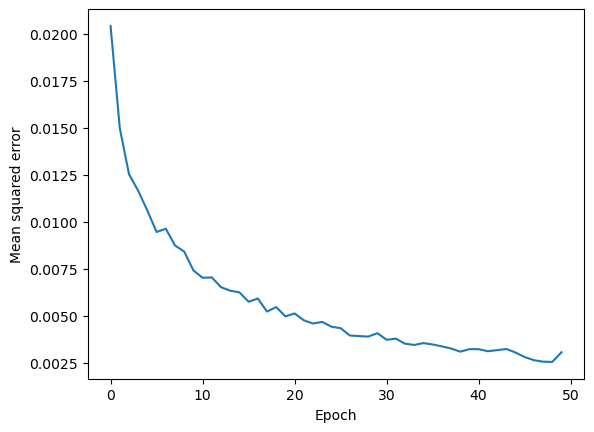

In [95]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

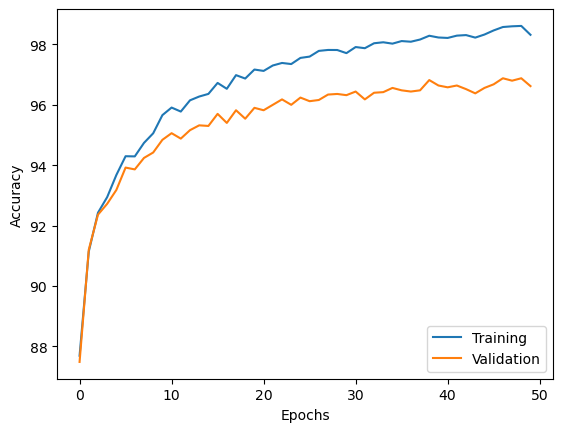

In [96]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [97]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 96.59%


Plot failure cases:

In [98]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, _, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

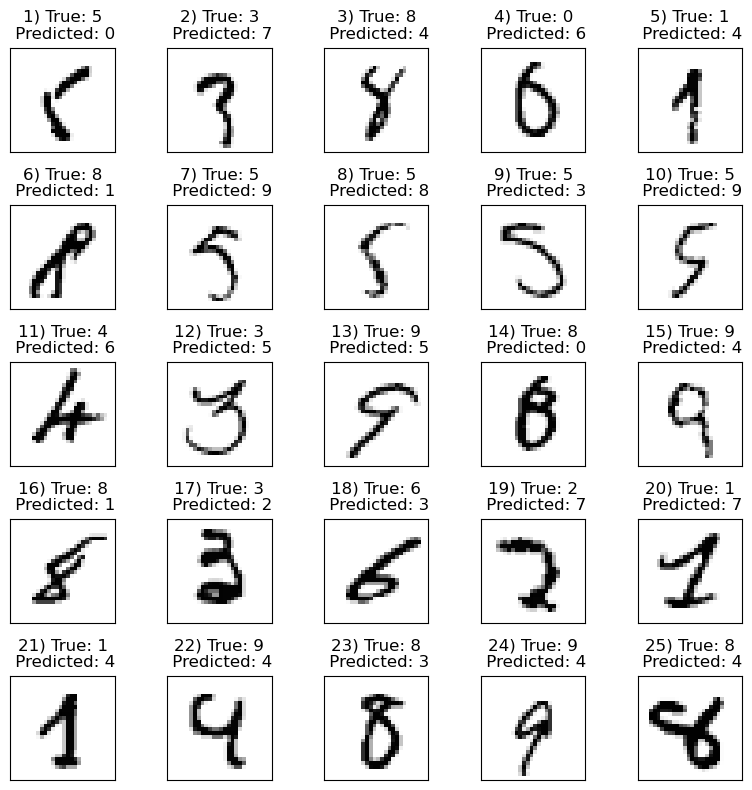

In [99]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()